### Build Causal Paths from CCC


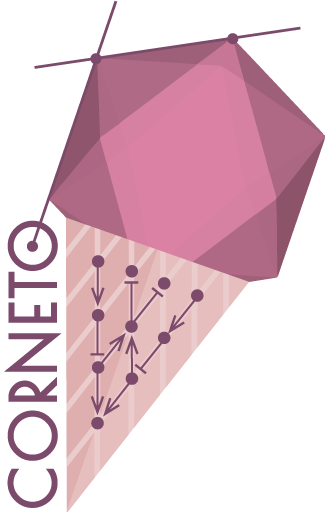

In [1]:
import os
import scanpy as sc
import pandas as pd

import liana as li
import corneto as cn
cn.info()

In [2]:
from scripts.utils import get_ppi

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Load Data

In [3]:
adata = sc.read_h5ad("data/adata_sub.h5ad")

In [4]:
acts = pd.read_csv(os.path.join('results', "acts_df.csv"), index_col=0)

In [5]:
groupby = 'cell_type'

Get Prior Knowledge

In [6]:
lr = li.rs.select_resource().rename(columns={'ligand': 'source', 'receptor': 'target'})
# assume most are positive; I checked specifically for PAUF/ZG16B
lr['mor'] = 1 
lr.head()

,source,target,mor
0,LGALS9,PTPRC,1
1,LGALS9,MET,1
2,LGALS9,CD44,1
3,LGALS9,LRP1,1
4,LGALS9,CD47,1


In [7]:
ppis = get_ppi(path=os.path.join("data", "ppis.csv"))
ppis = ppis.sort_values(['source', 'target', 'mor'])

Monocytes as targets of MGNs

In [8]:
add_pkn = lr[(lr['source'].isin(['TFF2', 'TFF3'])) & (lr['target'].isin(['CXCR4']))].copy()
add_pkn

,source,target,mor
2767,TFF2,CXCR4,1
2785,TFF3,CXCR4,1


In [9]:
input_pkn = pd.concat([ppis, add_pkn]).drop_duplicates()

Get Node Weights

In [10]:
target = "Monocyte"

In [11]:
temp = adata[(adata.obs[groupby] == target)].copy()

In [12]:
node_weights = pd.DataFrame(temp.X.getnnz(axis=0) / temp.n_obs, index=temp.var_names)
node_weights = node_weights.rename(columns={0: 'props'})
node_weights = node_weights['props'].to_dict()

Define input and output nodes

In [13]:
input_scores = {'TFF3': 1}

In [14]:
target_acts = acts[acts[groupby]==target]
target_acts = target_acts[target_acts['fdr'] <= 0.05]
# only keep those with tfs associated with STAT/NFKB/RELA signalling
target_acts = target_acts[target_acts['tf'].str.contains('|'.join(['STAT', 'NFKB', 'REL']))]

In [15]:
output_scores = target_acts.set_index('tf')[['activity']].to_dict()['activity']

{'NFKB': 2.5713763,
 'NFKB1': 4.9771967,
 'NFKB2': 6.6799808,
 'NFKBIB': 6.6496806,
 'REL': 4.339127,
 'RELA': 6.7939353,
 'RELB': 4.6223397,
 'STAT2': 4.6996174,
 'STAT3': 3.9144397,
 'STAT5A': 3.3452911,
 'STAT6': 3.1137955}

In [16]:
# convert the PPI network into a knowledge graph
prior_graph = li.mt.build_prior_network(input_pkn, input_scores, output_scores, verbose=True)

Importing network...
done.
 - Nodes x Edges: (4026, 8879)
 - Provided inputs included in the prior network: 1/1
 - Provided outputs included in the network: 10/11
Performing reachability analysis...
done.
 - Selected inputs: 1/1.
 - Selected outputs: 8/10.
 - Final size of the prior graph: (746, 3103).


In [17]:
# iterate over 100 seeds
dfs = {}
for i in range(100):
    dfs[i], _ = li.mt.find_causalnet(
                                    prior_graph,
                                    input_scores,
                                    output_scores,
                                    node_weights,
                                    node_cutoff=0.1,
                                    max_penalty=1,
                                    min_penalty=0.1,
                                    edge_penalty=0.2,
                                    verbose=False,
                                    seed=i,
                                    MIPGap=0,
                                    IntegralityFocus=1,
                                    solver='gurobi'
                                    )



Set parameter Username


Set parameter Username


Academic license - for non-commercial use only - expires 2025-01-04


Academic license - for non-commercial use only - expires 2025-01-04


In [18]:
res = {}
cols = ['source', 'target', 'edge_pred_val', 'target_pred_val', 'source_pred_val', 'source_type', 'target_type', 'edge_type']
for k in dfs.keys():
    df = dfs[k]
    df = df[~((df['source'].str.contains("_").fillna(False)) | (df['target'].str.contains("_").fillna(False)))]
    df = df[cols]
    res[k] = df.sort_values(cols)

In [19]:
df = pd.concat(res).drop_duplicates().sort_values(cols)

In [20]:
def count_row_occurrences(df_dict):
    # Concatenate all DataFrames into one
    combined_df = pd.concat(df_dict.values(), ignore_index=True)

    # Group by all columns and count occurrences of each unique row
    row_counts = combined_df.groupby(combined_df.columns.tolist()).size().reset_index(name='Count')
    row_counts['occurrence'] = row_counts['Count'] / len(df_dict)

    return row_counts.drop('Count', axis=1)

In [21]:
df = count_row_occurrences(res).sort_values(cols)

In [22]:
df.to_csv(os.path.join("results", f"causalpath_{target}.csv"))

In [43]:
df = pd.read_csv(os.path.join("results", f"causalpath_{target}.csv"), index_col=0)

In [44]:
# NOTE: append TFF2 as its network is identical to TFF3
add_row = df[df['source']=='TFF3']
add_row.loc[:, 'source'] = 'TFF2'
df = pd.concat([df, add_row])


In [45]:
df.head()

,source,target,edge_pred_val,target_pred_val,source_pred_val,source_type,target_type,edge_type,occurrence
0,ABL2,NFKBIB,1.0,1.0,1.0,unmeasured,output,1,1.00
1,APEX1,RELB,1.0,1.0,1.0,unmeasured,output,1,1.00
2,APEX1,STAT3,1.0,1.0,1.0,unmeasured,output,1,0.11
3,ATM,EP300,1.0,1.0,1.0,unmeasured,unmeasured,1,0.08
4,CREBBP,NFKB1,1.0,1.0,1.0,unmeasured,output,1,1.00


In [46]:
plot = cn.methods.carnival.visualize_network(df.dropna())

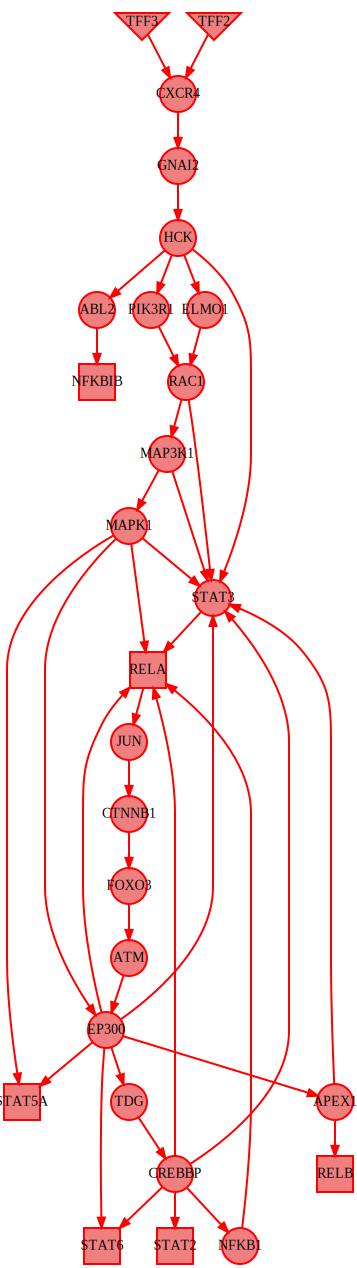

In [47]:
plot

In [48]:
plot.render(os.path.join("figures", f"causalpath_{target}"))

'figures/causalpath_Monocyte.pdf'

In [49]:
results = df.dropna()
# remove nodes that start with _
results = results[~ ((results['source'].str.startswith('_')) | (results['target'].str.startswith('_')))]

nodes = pd.concat([results[['source', 'source_type', 'source_pred_val']].rename(columns={'source': 'node', 'source_type': 'type', 'source_pred_val': 'sign'}),
                   results[['target', 'target_type', 'target_pred_val']].rename(columns={'target': 'node', 'target_type': 'type', 'target_pred_val': 'sign'})]).drop_duplicates().dropna()


In [50]:
edges = results[['source', 'target', 'edge_pred_val', 'occurrence']].dropna()

In [51]:
nodes.to_csv(f'results/nodes_{target}.csv')
edges.to_csv(f'results/edges_{target}.csv')